In [2]:
from matplotlib import ticker
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split

import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import random
from modeling  import Code2EEG
from utils import codeDistance
import pandas as pd
import os

# Generate real and simulated response sequence

### Load dataset

In [2]:
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

rep  = wholeset[0]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2']
chnINX = [wholeset[0]['channel'].index(i) for i in chnNames]

X = np.concatenate([sub['wn']['X'][:, chnINX] for sub in wholeset])
y = np.concatenate([sub['wn']['y'] for sub in wholeset])

S = rep['wn']['STI']
_class = np.unique(y)

### Modeling

In [3]:
srate = 250
winLEN = 1 
classNUM = 160
tmin, tmax = 0, .8
n_band = 3
# penalty
p = 0.9

code2EEG = Code2EEG(srate=srate, winLEN=winLEN, tmin=tmin, tmax=tmax, S=(S, _class), estimator=p, padding=True, n_band=n_band, component=1)
code2EEG.fit(X, y)

### Predict infinite number of response

In [4]:
refreshrate = 60
poolSize = int(1e4)

np.random.seed(253)
# re-create massive loads of STI patterns
buildSTI = np.random.uniform(0, 1, (int(poolSize), int(winLEN*refreshrate)))
# upsample
buildSTI = np.repeat(buildSTI, repeats=srate//refreshrate, axis=-1)

# additional STI
R_append = code2EEG.predict(buildSTI)

# org
R_org = code2EEG.predict(S)

# enhanced pattern
pattern = code2EEG.enhanced

# STI
STI = S.T

In [18]:
data = dict()
data['realPattern'] = np.transpose(pattern, (1, -1, 0))
data['simuPattern'] = np.transpose(R_org,(1,-1,0))
data['stiReal'] = STI

# simuLarge:建模的响应
data['simuLarge'] = np.transpose(R_append,(1,-1,0))
data['stiLarge'] = buildSTI

from scipy.io import savemat
# savemat("../opt/response.mat" , data)

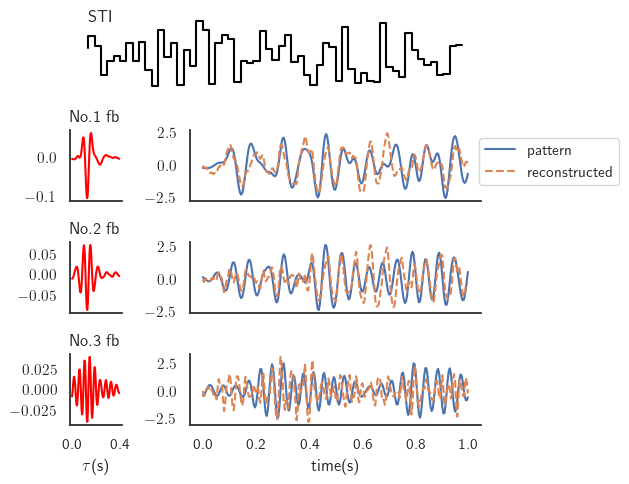

In [13]:
from scipy.signal import resample
inx = 2
sns.set_theme(style='white')
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(7, 5))
# set up subplot grid
GridSpec(4, 4)
# large subplot
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4, rowspan=1)

re_S = resample(S[inx],refreshrate)
ax1.step(np.arange(0,1,1/refreshrate),re_S, color='black')
ax1.set_axis_off()
ax1.text(x=0, y=1, s='STI')

for i in range(n_band):

    ax_k = plt.subplot2grid((4, 4), (i+1, 0), colspan=1, rowspan=1)
    ax_k.plot(code2EEG.trf[i, :100],color='red')

    ax_x = plt.subplot2grid((4, 4), (i+1, 1), colspan=3, rowspan=1)
    ax_x.plot(R_org[inx][i].T, label='pattern')
    ax_x.plot(pattern[inx][i].T, linestyle='dashed', label='reconstructed')
    ax_k.set_title('No.%s fb' % (i+1))

    if i == 0:
        ax_x.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

    if i != n_band-1:
        ax_k.xaxis.set_major_formatter(ticker.NullFormatter())
        ax_x.xaxis.set_major_formatter(ticker.NullFormatter())
    else:
        ax_k.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, pos: "%.1f" % (x/srate)))
        ax_x.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, pos: "%.1f" % (x/srate)))

ax_k.set_xlabel(r'$\tau$(s)')
ax_x.set_xlabel('time(s)')

sns.despine()
plt.tight_layout()
plt.savefig('../images/unified.svg', format='svg', dpi=300)

# Optimization Parameters

In [116]:
# with the increase of N

opts = loadmat('../opt/search.mat')['opt']
opts = np.squeeze(opts)
distanceLarge = [opt['distance'][0, 0] for opt in opts]
matLarge = np.stack([opt['mat'] for opt in opts])[-1]
matLarge = np.triu(matLarge, k=0)
matLarge[np.tril_indices(matLarge.shape[0], 0)] = np.nan

opts = loadmat('../opt/seq.mat')['opt']
opts = np.squeeze(opts)
matSmall = np.stack([opt['simulate']['mat'][0,0] for opt in opts])[-1]
matSmall = np.triu(matSmall, k=0)
matSmall[np.tril_indices(matSmall.shape[0], 0)] = np.nan

ns = np.arange(100,10000,1000)

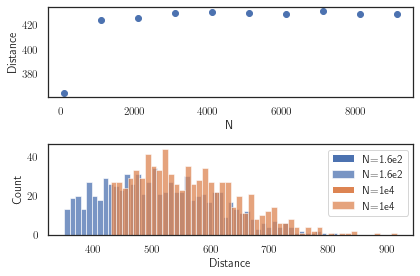

In [126]:
sns.set_theme(style='white')
f,(ax1,ax2) = plt.subplots(2,1)

sns.histplot(x=matSmall.flatten(),bins=50,label='N=1.6e2',ax=ax2)
sns.histplot(x=matLarge.flatten(),bins=50,label='N=1e4',ax=ax2)

ax1.scatter(ns,distanceLarge)
ax1.set_xlabel('N')
ax1.set_ylabel('Distance')

ax2.legend()
ax2.set_xlabel('Distance')

plt.tight_layout()
plt.savefig('../images/opt_hist.svg',dpi=300,format='svg')

# Optimization Efficiency

In [33]:
opt = []
add = '../results/sweep'
subs = os.listdir(add)
subs.remove('.DS_Store')
saveFILE = 'opt_random.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE
    if os.path.exists(s):
        # random
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        opt.append(f)
        # optimize
        f = pd.read_csv(subFolder+os.sep+'reheat.csv')
        opt.append(f)

opt = pd.concat(opt, ignore_index=True).drop_duplicates()
opt.loc[opt.opt=='random','tag'] = 'random'
opt = opt[opt.winLEN.isin(opt[opt.opt!='random'].winLEN.unique())]

opt.head()

,Unnamed: 0,score,winLEN,cv,seed,subject,opt,reheats,tag
0,0,0.600,0.3,0,0.0,chenyuzhen,random,NaN,random
1,1,0.550,0.3,1,0.0,chenyuzhen,random,NaN,random
2,2,0.525,0.3,2,0.0,chenyuzhen,random,NaN,random
3,3,0.625,0.3,3,0.0,chenyuzhen,random,NaN,random
4,4,0.600,0.3,4,0.0,chenyuzhen,random,NaN,random


In [34]:
ave = opt.groupby(by=['subject', 'winLEN','opt','tag',], as_index=False).mean()
ave.head()

,subject,winLEN,opt,tag,Unnamed: 0,score,cv,seed,reheats
0,chenyuzhen,0.3,random,random,2999.5,0.624000,2.5,499.5,NaN
1,chenyuzhen,0.3,real,customized,116.5,0.681944,2.5,NaN,2.0
2,chenyuzhen,0.3,real,group,8.5,0.690278,2.5,NaN,2.0
3,chenyuzhen,0.3,simulate,customized,170.5,0.677778,2.5,NaN,2.0
4,chenyuzhen,0.3,simulate,group,62.5,0.690278,2.5,NaN,2.0


### Group optimization

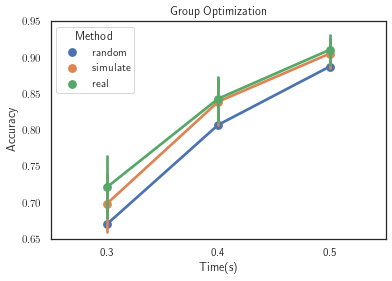

In [182]:
plt.rcParams['text.usetex'] = True

f,ax = plt.subplots()

sns.set_theme(style='whitegrid')
handle = sns.pointplot(data=opt[(opt.tag != 'customized')], x='winLEN',
              y='score', hue='opt',hue_order=['random','simulate','real'])
ax.set_ylim(0.65,0.95)

ax.set_xlabel('Time(s)')
ax.set_ylabel('Accuracy')

ax.legend(title='Method')
ax.set_title('Group Optimization')
plt.show()
f.savefig('../images/groupOpt.png',dpi=300)

### Customized optimization

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_25265/893863078.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=opt[(opt.opt == 'random')], x='winLEN',


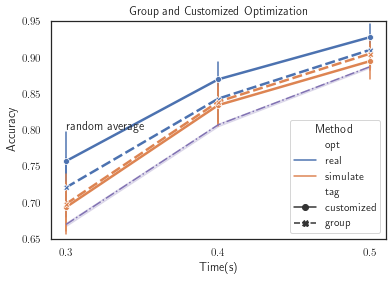

In [181]:
plt.rcParams['text.usetex'] = True

f,ax = plt.subplots()

sns.set_theme(style='white')
handle = sns.lineplot(data=opt[(opt.tag != 'random')], x='winLEN',
                      y='score', hue='opt', style='tag', markers=True, err_style="bars",linewidth=2.5,style_order=['customized','group'])
ax.set_ylim(0.65,0.95)


sns.lineplot(data=opt[(opt.opt == 'random')], x='winLEN',
             y='score', palette='Grays', linestyle='dashdot')

ax.text(x=0.3,y=0.8,s='random average')
ax.set_xlabel('Time(s)')
ax.set_ylabel('Accuracy')

ax.legend(title='Method')
ax.set_title('Group and Customized Optimization')

ax.xaxis.set_major_locator(ticker.FixedLocator([0.3,0.4,0.5]))
plt.show()
f.savefig('../images/groupvscus.svg',dpi=300,format='svg')

### with the best

In [35]:
ran = opt[opt.opt=='random'].groupby(by=['subject','winLEN','seed'],as_index=False).mean()

ranks = []
for winLEN in ran.winLEN.unique():
    for subject in ran.subject.unique():
        x = ran[(ran.winLEN==winLEN)&(ran.subject==subject)]
        x['rank'] = 'ave'
        x.loc[x.score == x.score.max(), 'rank'] = 'max'
        # x.loc[x.score==x.score.min(),'rank'] = 'min'

        ranks.append(x)

ranks = pd.concat(ranks,ignore_index=True)
ranks.head()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_38186/2243005712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['rank'] = 'ave'
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_38186/2243005712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['rank'] = 'ave'
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_38186/2243005712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,subject,winLEN,seed,Unnamed: 0,score,cv,reheats,rank
0,chenyuzhen,0.3,0.0,2.5,0.587500,2.5,NaN,ave
1,chenyuzhen,0.3,1.0,8.5,0.612500,2.5,NaN,ave
2,chenyuzhen,0.3,2.0,14.5,0.679167,2.5,NaN,ave
3,chenyuzhen,0.3,3.0,20.5,0.637500,2.5,NaN,ave
4,chenyuzhen,0.3,4.0,26.5,0.533333,2.5,NaN,ave


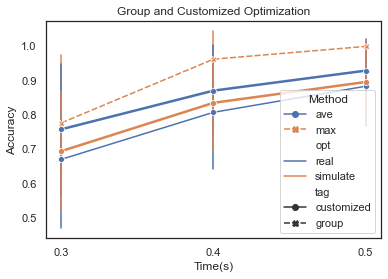

In [16]:
sns.set_theme(style='white')

f,ax = plt.subplots()

sns.lineplot(ranks, x='winLEN', y='score', hue='rank',
             markers=True, err_style="bars", errorbar='sd', style='rank')

sns.lineplot(data=opt[(opt.tag == 'customized')], x='winLEN',
                      y='score', hue='opt', style='tag', markers=True, err_style="bars", linewidth=2.5, style_order=['customized', 'group'],errorbar='sd')
ax.set_xlabel('Time(s)')
ax.set_ylabel('Accuracy')

ax.legend(title='Method')
ax.set_title('Group and Customized Optimization')

ax.xaxis.set_major_locator(ticker.FixedLocator([0.3, 0.4, 0.5]))
plt.show()

In [39]:
bestOpt = opt.loc[(opt.tag == 'customized')&(opt.opt=='real')]
bestOpt['rank'] = 'SA optimized'

optPicked = pd.concat([bestOpt,ranks],ignore_index=True)
optPicked.head()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_38186/171964868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestOpt['rank'] = 'SA optimized'


,Unnamed: 0,score,winLEN,cv,seed,subject,opt,reheats,tag,rank
0,108.0,0.750,0.3,0.0,NaN,chenyuzhen,real,0.0,customized,SA optimized
1,109.0,0.650,0.3,1.0,NaN,chenyuzhen,real,0.0,customized,SA optimized
2,110.0,0.775,0.3,2.0,NaN,chenyuzhen,real,0.0,customized,SA optimized
3,111.0,0.700,0.3,3.0,NaN,chenyuzhen,real,0.0,customized,SA optimized
4,112.0,0.600,0.3,4.0,NaN,chenyuzhen,real,0.0,customized,SA optimized


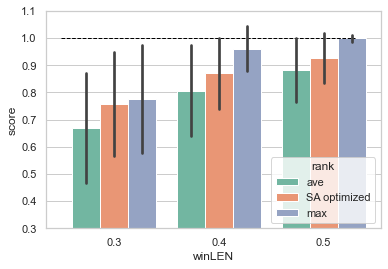

In [72]:
f,ax = plt.subplots()
sns.set_theme(style='whitegrid')
sns.barplot(optPicked, x='winLEN', y='score', hue='rank',
            errorbar='sd', hue_order=['ave', 'SA optimized', 'max'],palette='Set2')
ax.set_ylim(0.3,1.1)
# ax.legend(loc='best')

ax.hlines(y=1,xmin=-0.5,xmax=2.3,color='black',linestyles='dashed',linewidth=1)
f.savefig('../images/randomBest.png',dpi=300)

# For Group Optimization

In [4]:
groupOpt = []
add = '../results/sweep'
subs = os.listdir(add)
# subs.remove('.DS_Store')
saveFILE = 'groupOpt.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE

    if os.path.exists(s):
        # random
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        groupOpt.append(f)

groupOpt = pd.concat(groupOpt, ignore_index=True).drop_duplicates()
groupOpt.head()

,Unnamed: 0,accuracy,winLEN,method,cv,seed,subject
0,0,0.950,0.3,random,0,0,yangyuxing
1,1,0.950,0.3,random,0,1,yangyuxing
2,2,0.975,0.3,random,0,2,yangyuxing
3,3,0.925,0.3,random,0,3,yangyuxing
4,4,0.900,0.3,random,0,4,yangyuxing


In [5]:
ave = groupOpt.groupby(['subject','method','seed'], as_index=False).mean()
ave.head()

,subject,method,seed,Unnamed: 0,accuracy,winLEN,cv
0,chenyuzhen,random,0,7500.0,0.929167,0.3,2.5
1,chenyuzhen,random,1,7501.0,0.941667,0.3,2.5
2,chenyuzhen,random,2,7502.0,0.975000,0.3,2.5
3,chenyuzhen,random,3,7503.0,0.954167,0.3,2.5
4,chenyuzhen,random,4,7504.0,0.945833,0.3,2.5


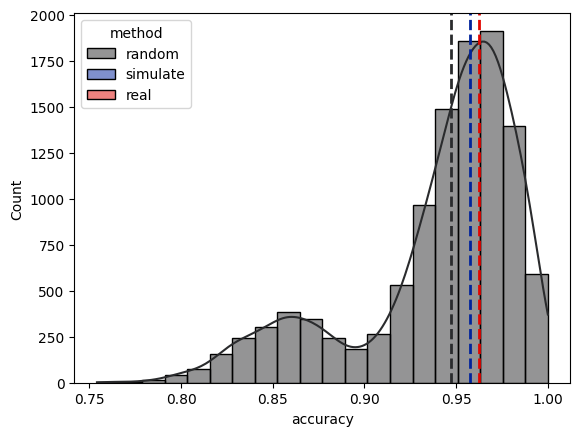

In [7]:
f,ax = plt.subplots()

hist = sns.histplot(data=ave[(ave.method == 'random')], x='accuracy', hue='method', hue_order=[
             'random', 'simulate', 'real'], bins=20, kde=True, palette=['#2A2B2DFF', '#00239CFF', '#E10600FF'],ax=ax,)

for (method, color) in zip(['random', 'simulate', 'real'], ['#2A2B2DFF', '#00239CFF', '#E10600FF']):
    value = ave[(ave.method == method)&(ave.subject!='shinanlin')].accuracy.mean()
    hist.axvline(x=value, linestyle='dashed', color=color,linewidth=2)

# f.savefig('../images/groupOptimization-all.png',dpi=500,format='png')

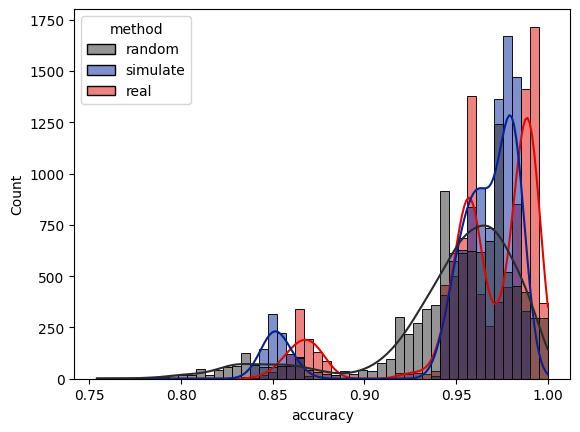

In [9]:
hist = sns.histplot(data=ave[(ave.subject != 'shinanlin')], x='accuracy', hue='method', hue_order=[
            'random', 'simulate', 'real'], bins=50, kde=True, palette=['#2A2B2DFF', '#00239CFF', '#E10600FF'],common_norm=False)

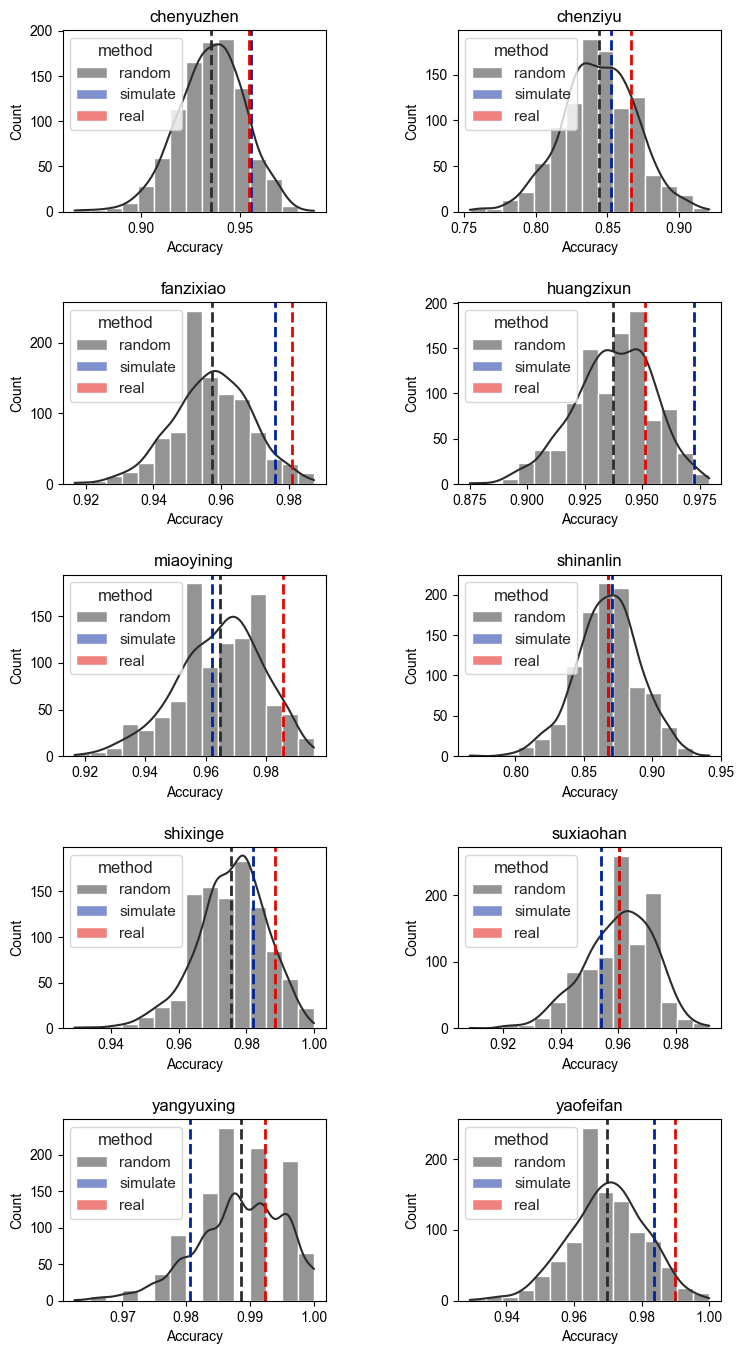

In [10]:
ave = groupOpt.groupby(['subject', 'seed', 'method'], as_index=False).mean()

n_sub = len(ave.subject.unique())
f,axes = plt.subplots(ncols=2,nrows=n_sub//2,figsize=(8.5,n_sub*1.5))

plt.subplots_adjust(wspace=0.5,hspace=0.5)

for (sub,ax) in zip(ave.subject.unique(),axes.flatten()):

    sns.set_theme(style='white')

    hist = sns.histplot(ave[(ave.method == 'random') & (ave.subject == sub)], x='accuracy', hue='method', fill=True, ax=ax, bins=15, kde=True, hue_order=['random', 'simulate','real'], palette=['#2A2B2DFF', '#00239CFF', '#E10600FF'])


    for (method,color) in zip(['random','simulate','real'],['#2A2B2DFF', '#00239CFF', '#E10600FF']):
        value = ave[(ave.method == method) & (
            ave.subject == sub)].accuracy.mean()
        
        hist.axvline(x=value, linestyle='dashed', color=color,linewidth=2)

    ax.set_title(sub)
    ax.set_xlabel('Accuracy')

f.savefig('../images/groupOptimization.png',dpi=500,format='png')

# Personalized Optimization

In [3]:
personOpt = []
add = '../results/sweep'
subs = os.listdir(add)
# subs.remove('.DS_Store')
saveFILE = 'personOpt.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE

    if os.path.exists(s):
        # random
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        personOpt.append(f)

personOpt = pd.concat(personOpt, ignore_index=True).drop_duplicates()
personOpt.head()


,Unnamed: 0,accuracy,winLEN,method,cv,seed,subject
0,0,0.925,0.3,random,0,0,yangyuxing
1,1,0.925,0.3,random,0,1,yangyuxing
2,2,0.925,0.3,random,0,2,yangyuxing
3,3,0.875,0.3,random,0,3,yangyuxing
4,4,0.900,0.3,random,0,4,yangyuxing


In [4]:
ave = personOpt.groupby(['subject', 'method', 'seed'], as_index=False).mean()
ave.head()

,subject,method,seed,Unnamed: 0,accuracy,winLEN,cv
0,chenyuzhen,random,0,20005.0,0.904167,0.3,2.5
1,chenyuzhen,random,1,20006.0,0.929167,0.3,2.5
2,chenyuzhen,random,2,20007.0,0.950000,0.3,2.5
3,chenyuzhen,random,3,20008.0,0.925000,0.3,2.5
4,chenyuzhen,random,4,20009.0,0.920833,0.3,2.5


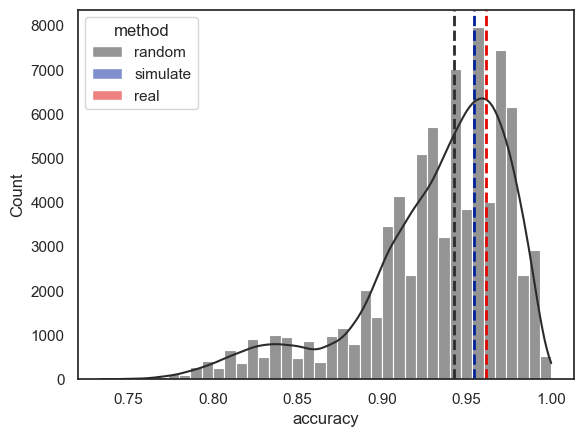

In [10]:
f, ax = plt.subplots()

hist = sns.histplot(data=ave[(ave.method == 'random')], x='accuracy', hue='method', hue_order=[
    'random', 'simulate', 'real'], bins=40, kde=True, palette=['#2A2B2DFF', '#00239CFF', '#E10600FF'], ax=ax,)

for (method, color) in zip(['random', 'simulate', 'real'], ['#2A2B2DFF', '#00239CFF', '#E10600FF']):
    value = ave[(ave.method == method) & (
        ~ave.subject.isin(['suxiaohan','shinanlin']))].accuracy.mean()
    hist.axvline(x=value, linestyle='dashed', color=color, linewidth=2)

# f.savefig('../images/groupOptimization-all.png',dpi=500,format='png')


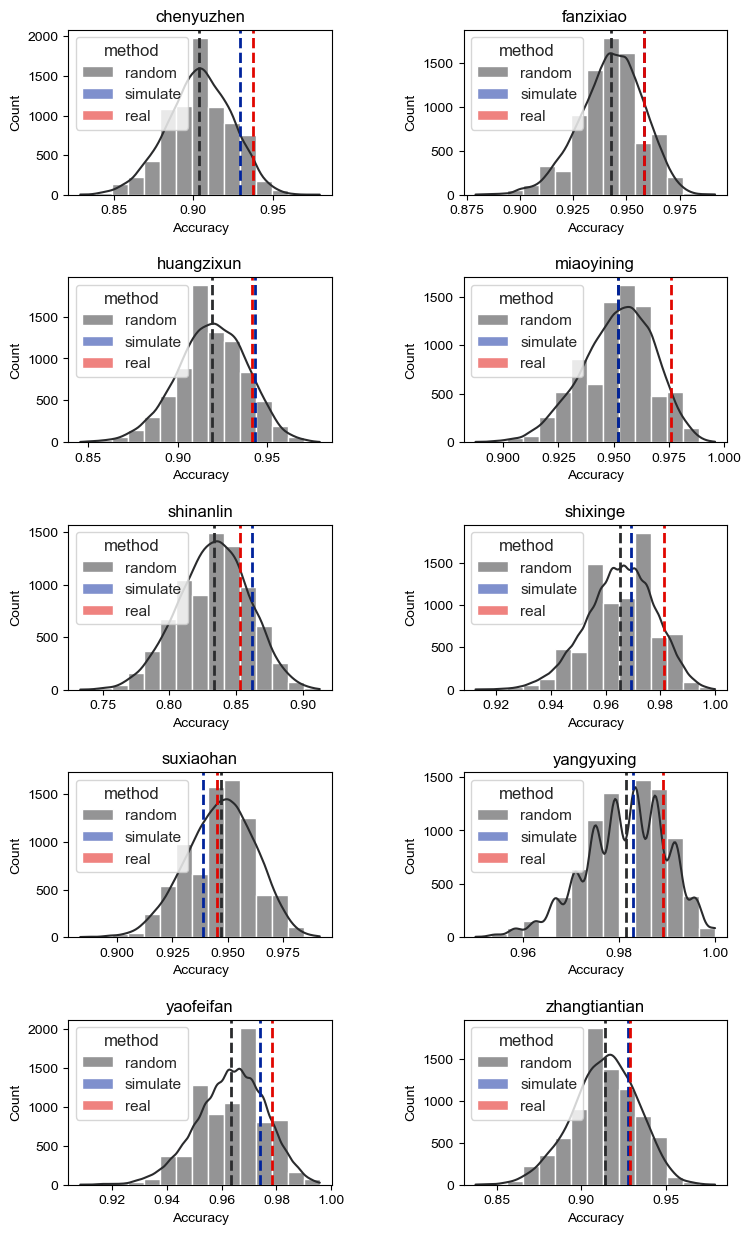

In [6]:
ave = personOpt.groupby(['subject', 'seed', 'method'], as_index=False).mean()

n_sub = len(ave.subject.unique())
f,axes = plt.subplots(ncols=2,nrows=n_sub//2,figsize=(8.5,n_sub*1.5))

plt.subplots_adjust(wspace=0.5,hspace=0.5)

for (sub,ax) in zip(ave.subject.unique(),axes.flatten()):

    sns.set_theme(style='white')

    hist = sns.histplot(ave[(ave.method == 'random') & (ave.subject == sub)], x='accuracy', hue='method', fill=True, ax=ax, bins=15, kde=True, hue_order=['random', 'simulate','real'], palette=['#2A2B2DFF', '#00239CFF', '#E10600FF'])


    for (method,color) in zip(['random','simulate','real'],['#2A2B2DFF', '#00239CFF', '#E10600FF']):
        value = ave[(ave.method == method) & (
            ave.subject == sub)].accuracy.mean()
        
        hist.axvline(x=value, linestyle='dashed', color=color,linewidth=2)

    ax.set_title(sub)
    ax.set_xlabel('Accuracy')

# f.savefig('../images/groupOptimization.png',dpi=500,format='png')

## Change a merit

In [91]:
opts = loadmat('../opt/seq.mat')['opt']

N = np.shape(opts)[-1]
M = 10

# 这里一定要+1！！！
realSeqs = np.concatenate([[opts[0,i]['real'][0,j]['code'] for j in range(M)] for i in range(N)])+1
simuSeqs = np.concatenate([[opts[0,i]['simulate'][0,j]['code'] for j in range(M)] for i in range(N)])+1

winLENs = np.concatenate([[opts[0,i]['winLEN'][0,0] for _ in range(M)] for i in range(N)])
optseeds = np.concatenate([[opts[0,i]['simulate'][0,j]['seed'][0,0] for j in range(M)] for i in range(N)])

mat = np.concatenate([[opts[0,i]['real'][0,j]['mat'] for j in range(M)] for i in range(N)])

In [73]:
frames = []

for i,(m,seed,winLEN) in enumerate(zip(mat,optseeds,winLENs)):
    # m = np.triu(m,k=0)

    s = opt[(opt.seed==seed)&(opt.winLEN==winLEN)&(opt.opt=='real')]

    m[np.tril_indices(m.shape[0], 0)] = np.nan

    f = pd.DataFrame(data=m,columns=np.arange(40),index=np.arange(40))

    f.reset_index(level=0, inplace=True)
    f = f.melt(id_vars='index', value_name='distance', var_name='class_1')
    f = f.rename(columns={'index': 'class_0'})

    f['seed'] = seed
    f['winLEN'] = winLEN
    f['score'] = s.score.mean()

    frames.append(f)

frames = pd.concat(frames)

NameError: name 'mat' is not defined

In [ ]:
opt[(opt.winLEN==0.5)&(opt.opt=='real')].groupby(['seed','subject']).mean()

In [69]:
frames[frames.winLEN==0.3].groupby(['seed','winLEN']).describe()[['distance','score']]

distance                                                          \
               count        mean        std      min         25%         50%   
seed winLEN                                                                    
1    0.3       780.0  130.476729  43.757730  61.9004   96.108633  124.003606   
2    0.3       780.0  131.454671  44.069165  61.9004   96.438334  124.954256   
3    0.3       780.0  129.692073  42.698422  61.9004   96.348518  122.992512   
4    0.3       780.0  129.698562  43.304762  61.9004   96.001900  123.213399   
5    0.3       780.0  133.060484  43.898827  61.9004   99.512300  126.278927   
6    0.3       780.0  134.438526  44.261395  61.9004  100.361625  129.271944   
7    0.3       780.0  132.984664  44.058980  61.9004   98.425107  126.504914   
8    0.3       780.0  131.793041  44.778246  61.9004   97.536758  124.572454   
9    0.3       780.0  131.025240  43.102067  61.9004   97.176973  123.981051   
10   0.3       780.0  133.458433  44.810991  61.9004   97.961841  127.456863   

                                      score                                    \
                    75%         max   count      mean           std       min   
seed winLEN                                                                     
1    0.3     158.621480  314.931334  1600.0  0.740833  2.498783e-14  0.740833   
2    0.3     159.864934  314.931334  1600.0  0.740833  2.498783e-14  0.740833   
3    0.3     157.500980  270.377242  1600.0  0.740833  2.498783e-14  0.740833   
4    0.3     158.191489  270.377242  1600.0  0.740833  2.498783e-14  0.740833   
5    0.3     161.215082  287.470731  1600.0  0.740833  2.498783e-14  0.740833   
6    0.3     164.100590  287.470731  1600.0  0.740833  2.498783e-14  0.740833   
7    0.3     162.144332  287.470731  1600.0  0.740833  2.498783e-14  0.740833   
8    0.3     159.882920  314.931334  1600.0  0.740833  2.498783e-14  0.740833   
9    0.3     160.017096  270.377242  1600.0  0.740833  2.498783e-14  0.740833   
10   0.3     162.385681  314.931334  1600.0  0.740833  2.498783e-14  0.740833   

                                                     
                  25%       50%       75%       max  
seed winLEN                                          
1    0.3     0.740833  0.740833  0.740833  0.740833  
2    0.3     0.740833  0.740833  0.740833  0.740833  
3    0.3     0.740833  0.740833  0.740833  0.740833  
4    0.3     0.740833  0.740833  0.740833  0.740833  
5    0.3     0.740833  0.740833  0.740833  0.740833  
6    0.3     0.740833  0.740833  0.740833  0.740833  
7    0.3     0.740833  0.740833  0.740833  0.740833  
8    0.3     0.740833  0.740833  0.740833  0.740833  
9    0.3     0.740833  0.740833  0.740833  0.740833  
10   0.3     0.740833  0.740833  0.740833  0.740833

In [3]:
dist = []
add = '../results/sweep'
subs = os.listdir(add)
subs.remove('.DS_Store')

saveFILE = 'optimize-coef-fb1.csv'

for sub in subs:
    subFolder = add+os.sep+sub 
    s = subFolder+os.sep+saveFILE
    if os.path.exists(s):
        f = pd.read_csv(subFolder+os.sep+saveFILE)
        dist.append(f)

dist = pd.concat(dist, ignore_index=True).drop_duplicates()

dist.head()

,Unnamed: 0,code-1,code-2,coef,type,subject,seed,score
0,0,0,0,NaN,code,chenyuzhen,0.0,0.354167
1,1,1,0,6.879875,code,chenyuzhen,0.0,0.354167
2,2,2,0,5.896847,code,chenyuzhen,0.0,0.354167
3,3,3,0,6.865895,code,chenyuzhen,0.0,0.354167
4,4,4,0,6.679992,code,chenyuzhen,0.0,0.354167


In [4]:
from statsmodels.stats.weightstats import ttest_ind

frames = []

for sub in dist.subject.unique():
    for seed in tqdm(dist.seed.unique()):
        for type in dist.type.unique():

            pick = dist[(dist.subject == sub) & (dist.seed == seed) & (dist.type == type)]
            coefs = pick.pivot_table(index='code-1', columns='code-2', values='coef')
            
            coefs = coefs.to_numpy()
            coefs = np.triu(coefs,k=0)
            coefs[np.tril_indices(coefs.shape[0], -1)] = np.nan
            coefsmin = np.sort(coefs)[0][:2].mean()

            row, col = np.triu_indices_from(coefs, k=1)
            x = coefs[row, col]
            
            p = []
            for i, e in enumerate(x):

                rest = np.delete(x, i)
                p.append(ttest_ind(rest, [e], alternative='larger')[1])
                
            pval = np.sort(p)[:2][0].sum()
                

            f = pd.DataFrame({
                'sub':sub,
                'coef':coefsmin,
                'seed':seed,
                'accuracy':pick.score.unique(),
                'type':type,
                'pval':pval
            })
            frames.append(f)
            
df = pd.concat(frames,ignore_index=True)

 23%|██▎       | 23/100 [00:28<01:36,  1.25s/it]


KeyboardInterrupt: 

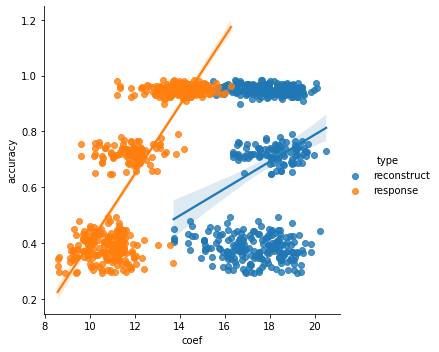

In [11]:
sns.lmplot(data=df[(df.type != 'code')], x='coef',y='accuracy', hue='type',)

<AxesSubplot:>

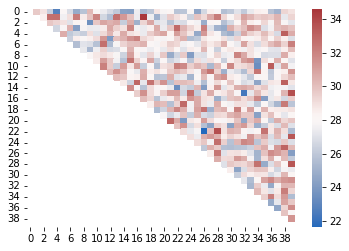

In [72]:
matrix = dist[(dist.seed == 1) & (dist.type == 'response')].pivot_table(
    index='code-1', columns='code-2', values='coef')

matrix = matrix.to_numpy()
matrix = np.triu(matrix,k=0)
matrix[np.tril_indices(matrix.shape[0], -1)] = np.nan

sns.heatmap(matrix,cmap='vlag')

In [75]:
dist = []
add = '../results/sweep'
subs = os.listdir(add)
subs.remove('.DS_Store')

saveFILE = 'optimize-coef.csv'
dist = pd.read_csv(add+os.sep+saveFILE)

dist.head()

,Unnamed: 0,distance,type,accuracy,seed
0,0,27.993942,response,0.528333,0
1,1,57.507109,reconstruct,0.528333,0
2,2,17.573533,code,0.528333,0
3,3,26.234041,response,0.548333,1
4,4,54.993483,reconstruct,0.548333,1


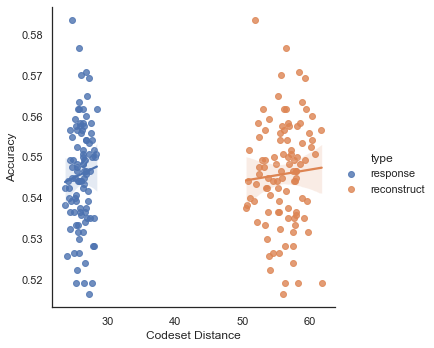

In [124]:
sns.set_theme(style='white')
g = sns.lmplot(data=dist[dist.type != 'code'],x='distance', y='accuracy', hue='type')
g.set_axis_labels("Codeset Distance", "Accuracy")
plt.savefig('../images/codedistance',dpi=300)